<a href="https://colab.research.google.com/github/Mfths/2025_PBO_IFA/blob/main/Praktikum_VISKOM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)**

1)	Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32)
  # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)

2)	“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label



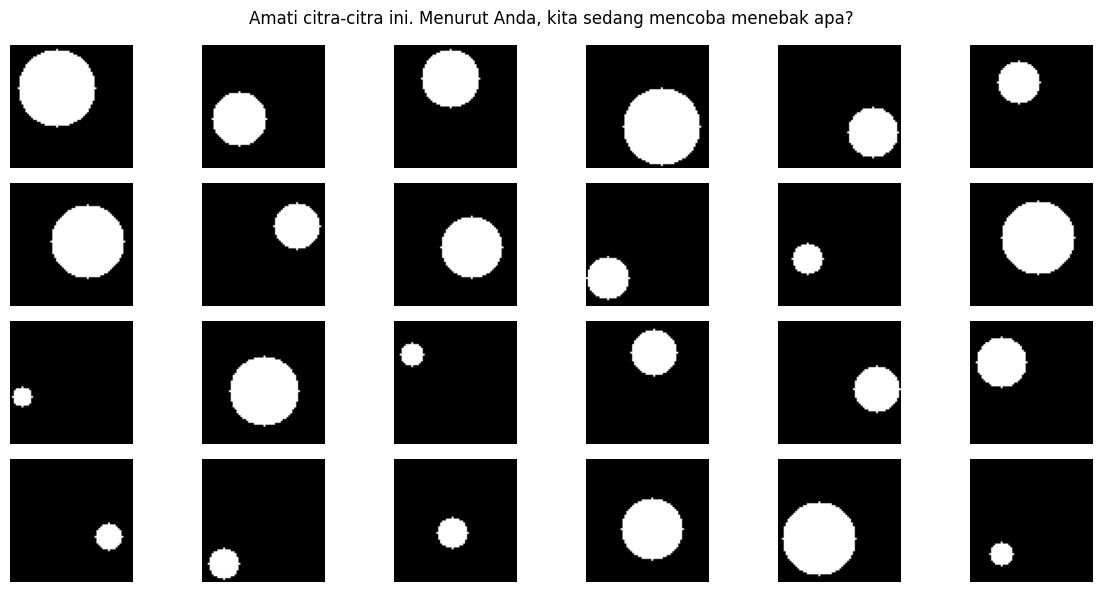

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

3)	Buka Jawaban — Target yang Ingin Diprediksi

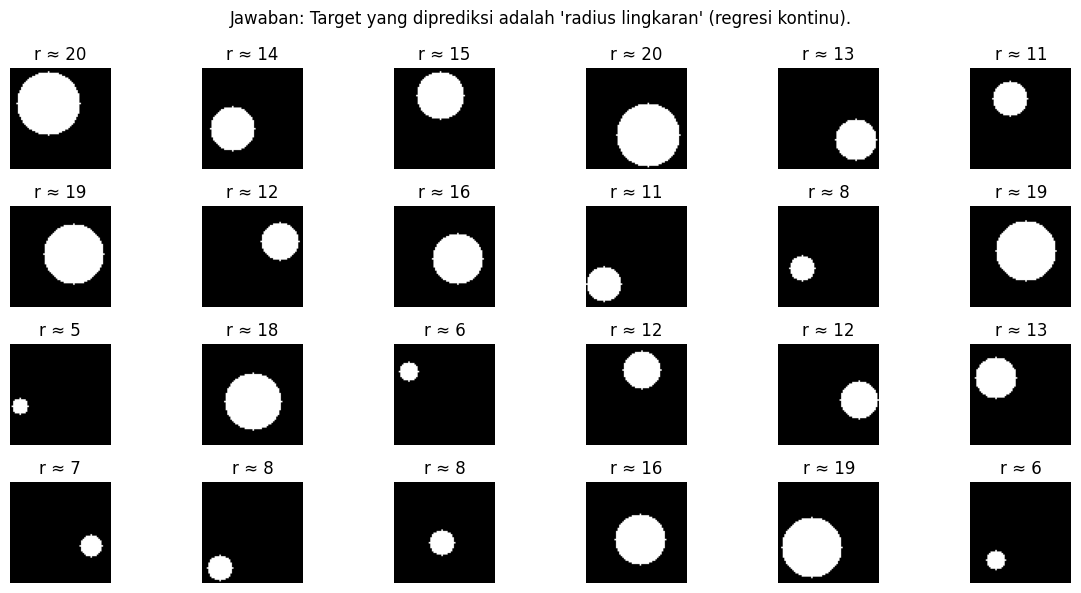

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

4)	(Opsional) Latih CNN Kecil untuk Memprediksi Radius



In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MAE=0.943 | RMSE=1.157 | R²=0.935


Plot history & True vs Predicted:

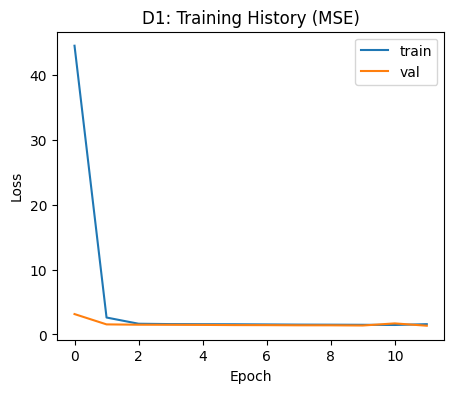

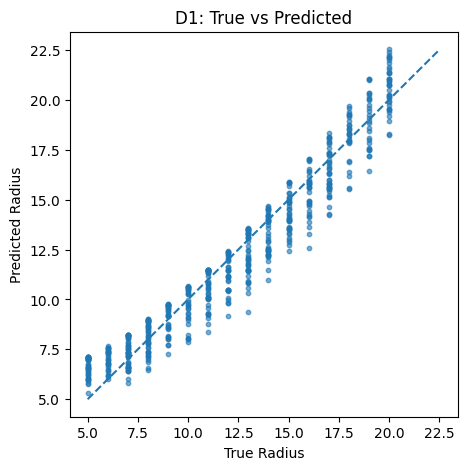

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
y_pred = y_pred.flatten()   # <-- tambahkan baris ini!
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


5)	Tantangan Mini (Opsional untuk Mahasiswa)

a. Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
b. Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
c. Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?


**Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)**


Langkah 2 — Mengunggah kaggle.json ke Colab

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sitimiftahussadiyah","key":"82e70a9b626236d02d79dbde4e15eb74"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Langkah 4 — Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


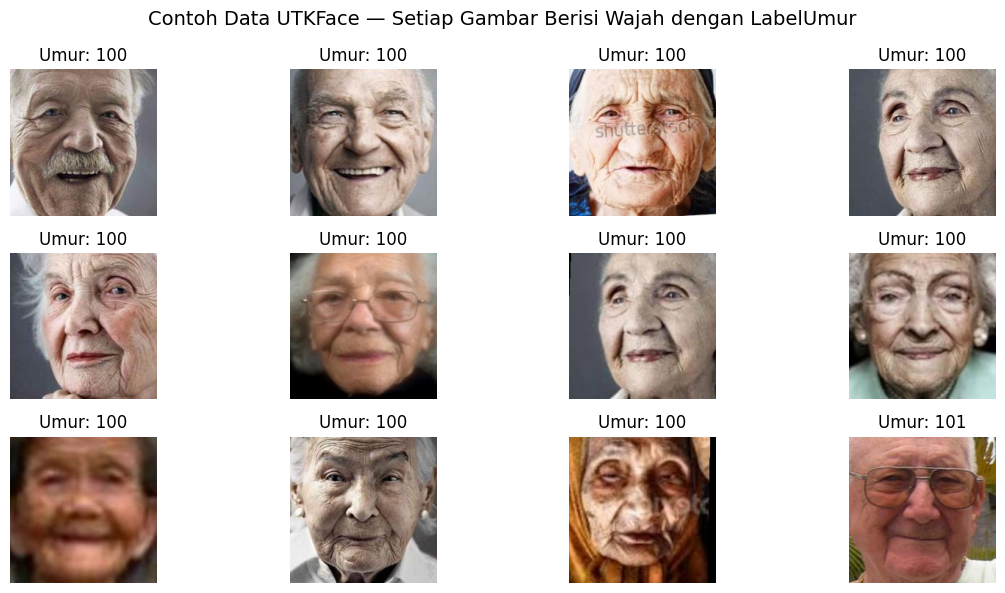

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan LabelUmur", fontsize=14)
plt.tight_layout()
plt.show()

Langkah 5 — Siapkan Dataset untuk Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
files, ages, test_size=0.2, random_state=42)
IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label
train_ds = tf.data.Dataset.from_tensor_slices((train_files,
y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,
y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


Langkah 6 — Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else"CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
include_top=False,
input_shape=(IMG_SIZE, IMG_SIZE, 3),
weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse', metrics=['mae'])

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 55s 127ms/step - loss: 345.3721 - mae: 13.6221 - val_loss: 160.6912 - val_mae: 9.6556 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 156.5055 - mae: 9.3223 - val_loss: 147.9911 - val_mae: 9.1624 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 145.1840 - mae: 8.9104 - val_loss: 143.3824 - val_mae: 8.9879 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 141.7560 - mae: 8.7590 - val_loss: 140.3497 - val_mae: 8.8646 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 139.9722 - mae: 8.6407 - val_loss: 138.2481 - val_mae: 8.7521 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 138.4594 - mae: 8.6057 - val_loss: 138.1279 - val_mae: 8.7257 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 135.9509 - mae: 8.5336 - val_loss: 136.1801 - va

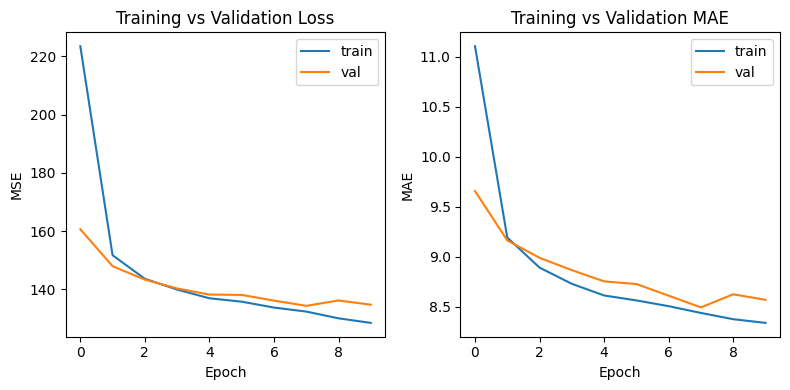

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
  ]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
  )

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')

plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Langkah 8 — Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 99ms/step - loss: 192.6708 - mae: 10.1914 - val_loss: 147.9152 - val_mae: 8.9754 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 78.6794 - mae: 6.5518 - val_loss: 126.5294 - val_mae: 8.4448 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 52.0435 - mae: 5.4012 - val_loss: 113.0407 - val_mae: 7.8897 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 38.1963 - mae: 4.6596 - val_loss: 105.9368 - val_mae: 7.3767 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 30.6953 - mae: 4.2077 - val_loss: 106.2905 - val_mae: 7.3327 - learning_rate: 1.0000e-04


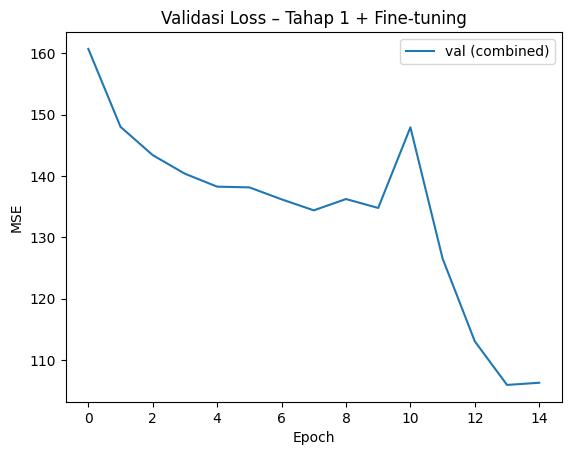

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
history_ft = model.fit(
    train_ds, validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()


Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.57 tahun
RMSE = 10.36 tahun
R²	= 0.729


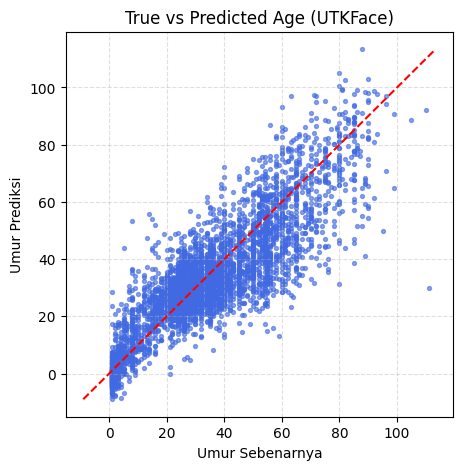

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²	= {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Langkah 10 — Melihat Contoh Prediksi Nyata

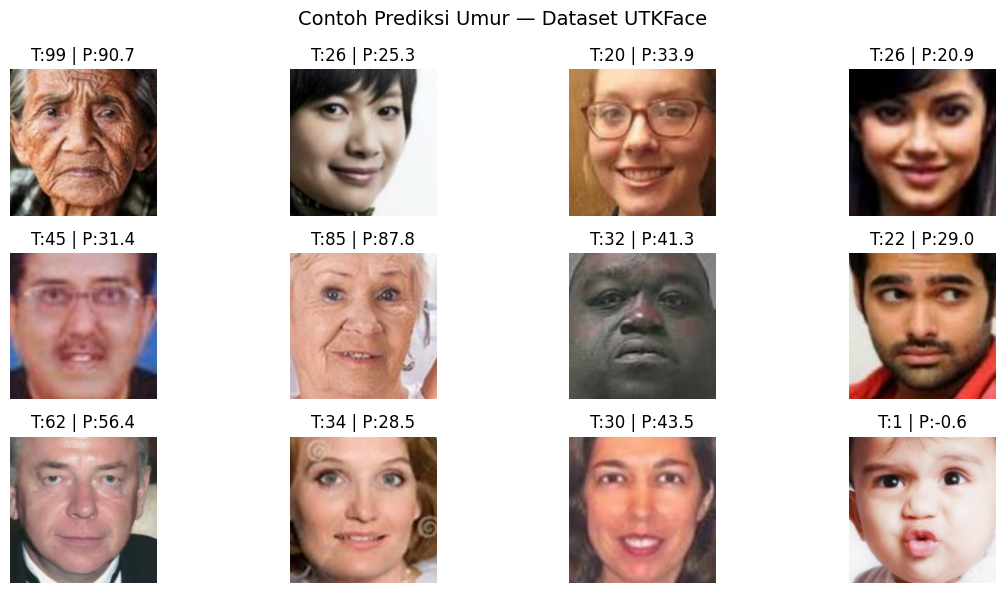

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

**Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto**

Langkah 1 — Menyiapkan Kaggle API



In [ ]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle (5).json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle (5).json", os.path.expanduser("~/.kaggle/kaggle (5).json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle (5).json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" ı. kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle (5).json to kaggle (5).json
✅ Kaggle API siap digunakan.


Langkah 2 — Mengunduh dan Mengekstrak Dataset

In [ ]:
!mkdir -p ~/.kaggle
!mv "/content/kaggle (5).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle


total 8
-rw------- 1 root root 75 Oct 21 16:25 'kaggle (5).json'
-rw------- 1 root root 75 Oct 21 16:25  kaggle.json


In [ ]:
!mkdir -p /content/paw
!kaggle competitions download -c petfinder-pawpularity-score -p /content/paw

 95% 938M/983M [00:11<00:01, 46.7MB/s]
100% 983M/983M [00:11<00:00, 93.2MB/s]


In [ ]:
!unzip -q /content/paw/petfinder-pawpularity-score.zip -d /content/paw
!ls /content/paw


petfinder-pawpularity-score.zip  test	   train
sample_submission.csv		 test.csv  train.csv


In [ ]:
!mkdir -p ~/.kaggle
!mv "kaggle (5).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p /content/paw
!kaggle competitions download -c petfinder-pawpularity-score -p /content/paw


 96% 948M/983M [00:09<00:00, 47.5MB/s]
100% 983M/983M [00:09<00:00, 105MB/s] 


In [ ]:
!unzip /content/paw/petfinder-pawpularity-score.zip -d /content/paw
!ls /content/paw

Streaming output truncated to the last 5000 lines.
  inflating: /content/paw/train/7e56aa71d1e091e004703283323e8e7f.jpg  
  inflating: /content/paw/train/7e5d1650d5cda4d68f2ee8ce17c29b25.jpg  
  inflating: /content/paw/train/7e601feb12f2fb03c2d342e54cd47b1e.jpg  
  inflating: /content/paw/train/7e6ca633d2a751af58e1cc220ca519b3.jpg  
  inflating: /content/paw/train/7e717923c22053e51861a24aae701fb0.jpg  
  inflating: /content/paw/train/7e761f47cc1e3038a431f9f196234ab9.jpg  
  inflating: /content/paw/train/7e7921ed945c3c863882340360c9157d.jpg  
  inflating: /content/paw/train/7e8763e28a01c059b7a8d119c5ae0dc0.jpg  
  inflating: /content/paw/train/7e93691bef9bc381590cf004358ee11a.jpg  
  inflating: /content/paw/train/7e947e83394b6d74f1ec4f5b596bed6a.jpg  
  inflating: /content/paw/train/7e9d46bd87849a49ada5f2c336c9d929.jpg  
  inflating: /content/paw/train/7e9df6c36fd06411ce717d0ce761af35.jpg  
  inflating: /content/paw/train/7ea78b0c0bb036b1bbb76b99ec0b731c.jpg  
  inflating: /content/paw/

Langkah 3 — Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

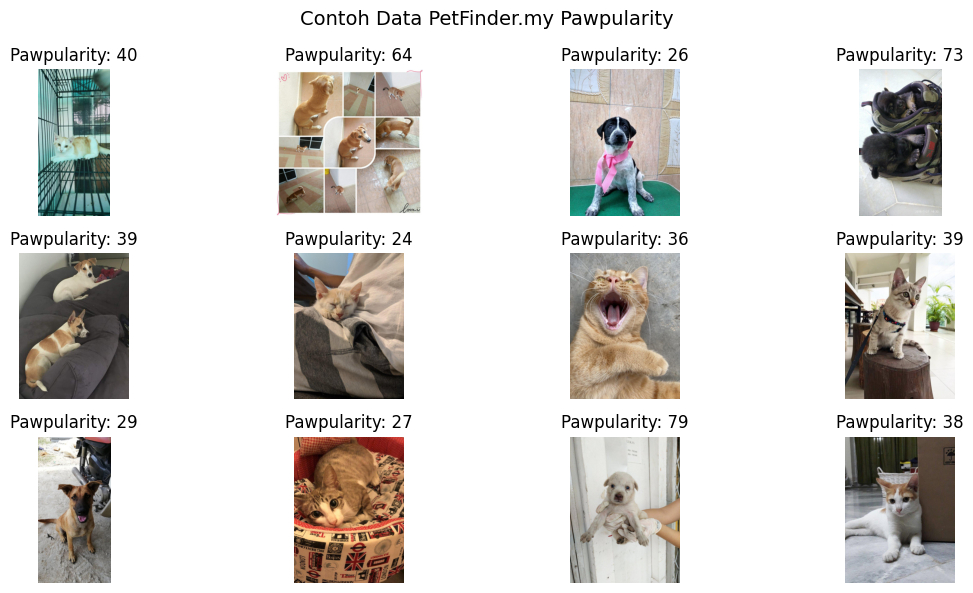

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Langkah 4 — Persiapan Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
  .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
  .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 4 — Membangun Model (EfficientNetB0)

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Langkah 5 — Melatih Model

In [ ]:
import tensorflow as tf

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# --- Simpan model setelah training selesai ---
model.save('/content/paw/model_pawpularity.h5')
print("✅ Model tersimpan di /content/paw/model_pawpularity.h5")


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 120s 570ms/step - loss: 823.9203 - mae: 21.5888 - val_loss: 475.4727 - val_mae: 16.0650 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 233ms/step - loss: 432.9316 - mae: 15.4593 - val_loss: 423.5274 - val_mae: 15.0957 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - loss: 393.2864 - mae: 14.6889 - val_loss: 404.2067 - val_mae: 15.0000 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - loss: 379.3034 - mae: 14.3984 - val_loss: 389.4772 - val_mae: 14.4156 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - loss: 356.4270 - mae: 13.9142 - val_loss: 380.1762 - val_mae: 14.3400 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 231ms/step - loss: 350.0387 - mae: 13.8193 - val_loss: 373.3998 - val_mae: 14.3043 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - loss: 337.2551 - mae: 13.7243 - val_

✅ Model tersimpan di /content/paw/model_pawpularity.h5


Langkah 6 — Melihat Proses Belajar

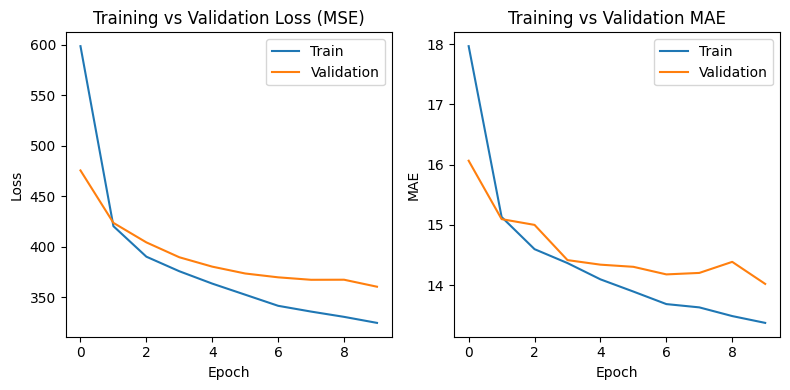

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

Langkah 7 — Evaluasi Model

MAE = 14.02
RMSE = 18.98
R²	= 0.185


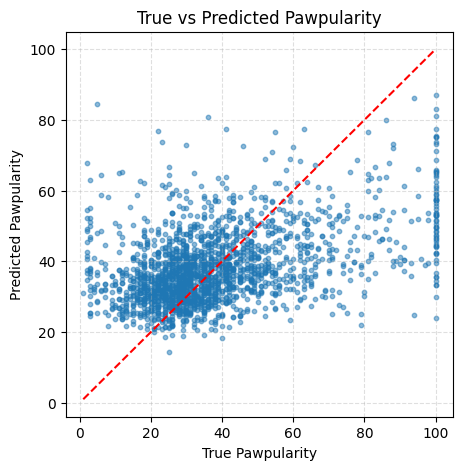

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²	= {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Langkah 8 — Melihat Contoh Prediksi

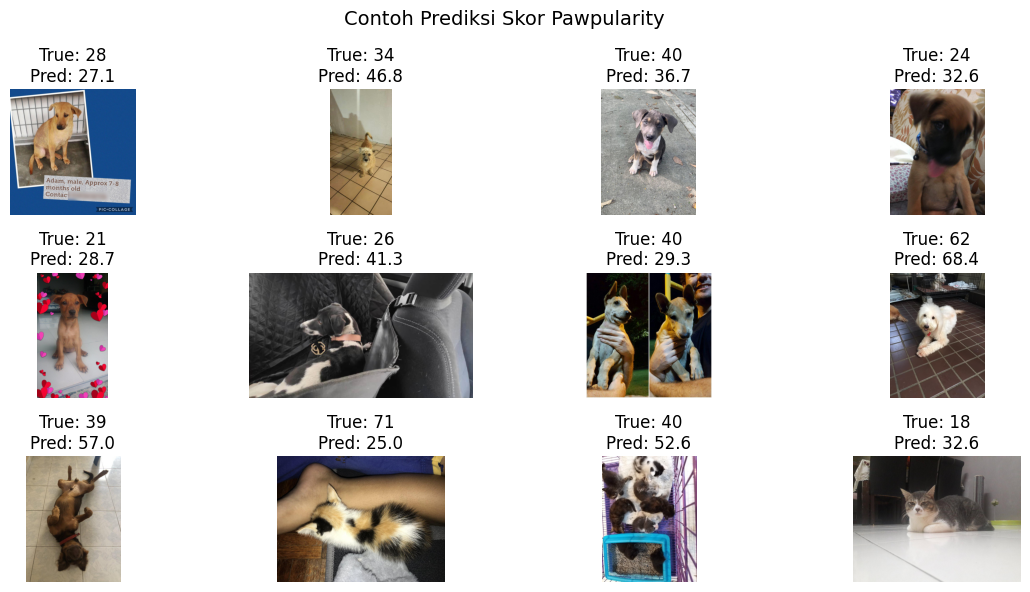

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path,
row.Pawpularity)[0], 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

PENUGASAN 1 (PREDIKSI UMUR DARI WAJAH)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sitimiftahussadiyah","key":"82e70a9b626236d02d79dbde4e15eb74"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Saving ifa3.jpeg to ifa3.jpeg
📏 Ukuran asli gambar: (960, 1280)
🎯 Diubah menjadi: (160, 160)


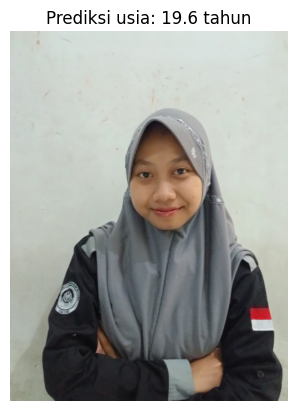

📊 Usia diprediksi: 19.6 tahun


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Unggah gambar
from google.colab import files
uploaded = files.upload()

# Ambil file
img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert('RGB')

# --- Cek ukuran asli ---
print("📏 Ukuran asli gambar:", img.size)

# --- Ubah ukuran otomatis sesuai model ---
target_size = (160, 160)  # sesuaikan dengan model kamu
img_resized = img.resize(target_size)
print("🎯 Diubah menjadi:", target_size)

# --- Ubah jadi array ---
img_array = np.array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# --- Prediksi umur ---
pred_age = model.predict(img_array, verbose=0)[0][0]

# --- Tampilkan hasil ---
plt.imshow(img)
plt.title(f"Prediksi usia: {pred_age:.1f} tahun")
plt.axis('off')
plt.show()

print(f"📊 Usia diprediksi: {pred_age:.1f} tahun")


PENUGASAN 2

In [ ]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle (5).json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle (5).json", os.path.expanduser("~/.kaggle/kaggle (5).json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle (5).json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" ı. kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle (5).json to kaggle (5).json
✅ Kaggle API siap digunakan.


In [ ]:
!mkdir -p ~/.kaggle
!mv "/content/kaggle (5).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle

total 8
-rw------- 1 root root 75 Oct 22 16:29 'kaggle (5).json'
-rw------- 1 root root 75 Oct 22 16:29  kaggle.json


In [ ]:
!mkdir -p /content/paw
!kaggle competitions download -c petfinder-pawpularity-score -p /content/paw

 98% 960M/983M [00:05<00:00, 120MB/s]
100% 983M/983M [00:05<00:00, 192MB/s]


In [ ]:
!unzip -q /content/paw/petfinder-pawpularity-score.zip -d /content/paw
!ls /content/paw

petfinder-pawpularity-score.zip  test	   train
sample_submission.csv		 test.csv  train.csv


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

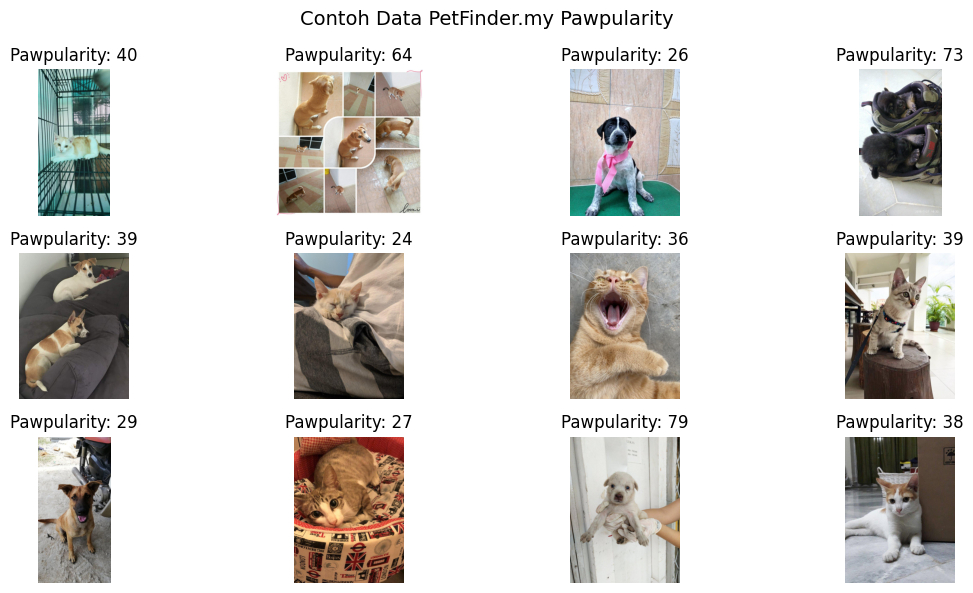

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import tensorflow as tf

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# --- Simpan model setelah training selesai ---
model.save('/content/paw/model_pawpularity.h5')
print("✅ Model tersimpan di /content/paw/model_pawpularity.h5")

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - loss: 819.7947 - mae: 21.5052 - val_loss: 478.3997 - val_mae: 16.0123 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - loss: 416.2268 - mae: 15.1568 - val_loss: 426.7631 - val_mae: 15.4365 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - loss: 390.7054 - mae: 14.6055 - val_loss: 401.0597 - val_mae: 14.6194 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - loss: 377.4297 - mae: 14.3421 - val_loss: 388.4756 - val_mae: 14.5306 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - loss: 370.5640 - mae: 14.4203 - val_loss: 378.3520 - val_mae: 14.2945 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - loss: 340.4433 - mae: 13.6967 - val_loss: 374.1176 - val_mae: 13.9913 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - loss: 336.0696 - mae: 13.6386 - val_loss: 367.1118 

✅ Model tersimpan di /content/paw/model_pawpularity.h5


✅ Model berhasil dimuat ulang.
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
🐾 Skor Pawpularity Prediksi: 12.42


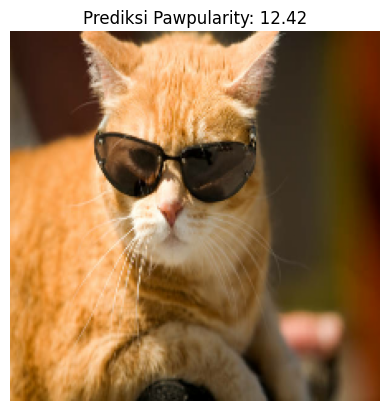

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

IMG_SIZE = 224

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze layer base

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)  # sesuai model training
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

model.load_weights('/content/paw/model_pawpularity.h5')
print("✅ Model berhasil dimuat ulang.")

img_path = '/content/kucing 1.jpg'   # pastikan path-nya benar

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = tf.cast(img, tf.float32) / 255.0   # normalisasi sama kayak di load_image()

pred = model.predict(tf.expand_dims(img, 0))[0][0]
print(f"🐾 Skor Pawpularity Prediksi: {pred:.2f}")

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi Pawpularity: {pred:.2f}")
plt.show()
